In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

os.chdir(os.path.join(os.getcwd(), '..'))

from data import PollenDataset

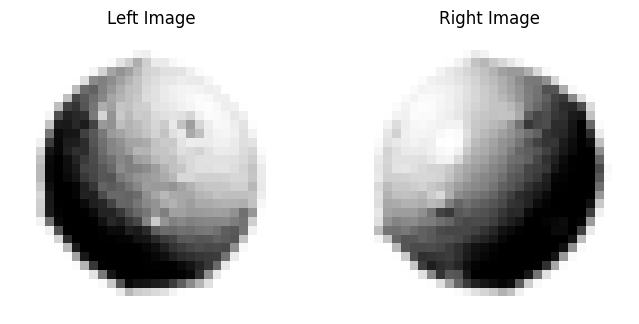

In [35]:
image_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = PollenDataset(image_transforms=image_transforms)

(left_img, right_img), rotation, voxels = dataset[0]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(left_img.permute(1,2,0), cmap='gray')
plt.title("Left Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(right_img.permute(1,2,0), cmap='gray')
plt.title("Right Image")
plt.axis("off")
plt.show()

In [30]:
import torch
import torch.nn.functional as F
import lightning.pytorch as pl
from typing import List

from core.metrics import MetricsMixin

class VisualHull(MetricsMixin, pl.LightningModule):
    """
    Constructs a Visual Hull from one or more silhouette images.

    This implementation uses a back-projection technique to carve a solid
    volume using each provided silhouette. It assumes the input images are
    views of an object from cameras rotating around the Y-axis at fixed
    azimuth angles.
    """
    def __init__(self):
        super().__init__()
        self.angles_deg = [0, 90, 180, 270, 45, 135, 225, 315] # angles corresponding to the views in PollenDataset, as per ImageGenerator

    def _create_rotation_matrix_y(self, angle_rad: torch.Tensor) -> torch.Tensor:
        """Creates a 3x3 rotation matrix for rotation around the Y-axis."""
        cos_a = torch.cos(angle_rad)
        sin_a = torch.sin(angle_rad)
        return torch.tensor([
            [cos_a,  0,  sin_a],
            [0,      1,      0],
            [-sin_a, 0,  cos_a]
        ])

    def forward(
        self,
        images: List[torch.Tensor],
        step: int = 1
    ) -> torch.Tensor:
        """
        Generates a visual hull from a list of silhouette images.

        Args:
            images (List[torch.Tensor]): A list of silhouette tensors. Expected shape
                                         is (B, H, W) or (B, 1, H, W).
            step (int): Down-sampling step for the final volume.

        Returns:
            torch.Tensor: A boolean tensor representing the visual hull,
                          of shape (B, H_out, W_out, D_out).
        """
        if not images:
            return torch.empty(0)

        processed_images = []
        for img in images:
            if img.dim() == 3:
                processed_images.append(img.unsqueeze(1))
            elif img.dim() == 4:
                processed_images.append(img)
            else:
                raise ValueError(f"Unsupported image tensor dimension: {img.dim()}. Expected 3 or 4.")
        
        B, _, H, W = processed_images[0].shape
        device = processed_images[0].device
        D = W

        visual_hull = torch.ones((B, H, W, D), dtype=torch.bool, device=device)

        coords_x = torch.linspace(-1, 1, W, device=device)
        coords_y = torch.linspace(-1, 1, H, device=device)
        coords_z = torch.linspace(-1, 1, D, device=device)
        grid_y, grid_x, grid_z = torch.meshgrid(coords_y, coords_x, coords_z, indexing='ij')
        grid_coords = torch.stack([grid_x, grid_y, grid_z], dim=-1)
        grid_coords = grid_coords.unsqueeze(0).expand(B, -1, -1, -1, -1)

        for i, sil_image in enumerate(processed_images):
            if i >= len(self.angles_deg):
                break
                
            angle_rad = -torch.deg2rad(torch.tensor(self.angles_deg[i], device=device, dtype=torch.float32))
            rotation_matrix = self._create_rotation_matrix_y(angle_rad).to(device)

            rotated_grid = grid_coords @ rotation_matrix.T
            sample_coords = rotated_grid[..., [0, 1]]
            sample_coords_flat = sample_coords.reshape(B, H * W, D, 2)

            sil_image_float = (sil_image < 1.0).to(torch.float32)

            back_projected_vol_flat = F.grid_sample(
                input=sil_image_float,
                grid=sample_coords_flat,
                mode='bilinear',
                padding_mode='zeros',
                align_corners=True
            )

            back_projected_vol = back_projected_vol_flat.reshape(B, 1, H, W, D)
            carved_mask = (back_projected_vol > 0.5).squeeze(1)

            visual_hull &= carved_mask

        if step > 1:
            visual_hull = visual_hull[:, ::step, ::step, ::step]

        return visual_hull

    def training_step(self, batch, batch_idx):
        images_tuple, _, voxels = batch
        y_pred = self(list(images_tuple))
        self.log_train_metrics(y_pred, voxels)

    def validation_step(self, batch, batch_idx):
        images_tuple, _, voxels = batch
        y_pred = self(list(images_tuple))
        self.log_val_metrics(y_pred, voxels)

    def configure_optimizers(self):
        return None

In [55]:
dataset = PollenDataset(image_transforms=image_transforms, n_images=5)

In [56]:
vh = VisualHull()

views, rot, vox = dataset[0]

out = vh(views)

In [57]:
out_simplified = out.squeeze(0)  # Down-sample by 2 for visualization

In [58]:
out_simplified.shape

torch.Size([32, 32, 32])

{(np.int64(2),
  np.int64(14),
  np.int64(16)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1708c988fd0>,
 (np.int64(2),
  np.int64(14),
  np.int64(18)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1708fa84c90>,
 (np.int64(2),
  np.int64(15),
  np.int64(16)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1708fcf2150>,
 (np.int64(2),
  np.int64(15),
  np.int64(18)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1708fcf3cd0>,
 (np.int64(2),
  np.int64(16),
  np.int64(17)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1708fd04e10>,
 (np.int64(2),
  np.int64(16),
  np.int64(18)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1708fd061d0>,
 (np.int64(3),
  np.int64(11),
  np.int64(11)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1708fd078d0>,
 (np.int64(3),
  np.int64(11),
  np.int64(18)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1708fd10fd0>,
 (np.int64(3),
  np.int64(12),
  np.int64(11)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1708fd

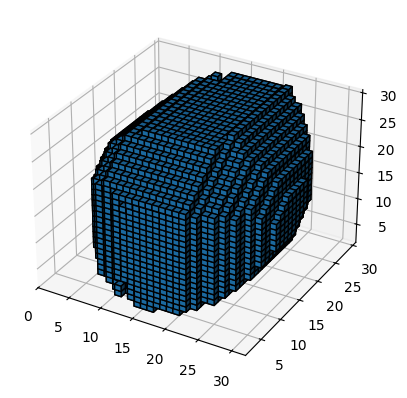

In [59]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(out_simplified, edgecolor='k')